In [1]:
!pip install -U sentence-transformers
!pip install skillsnetwork

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 116.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 112.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.8 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=f64a9765a3d9e3877d2335b4d09b8a829897c32579288bd7bbb81c3c3997db8f
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.5 MB/s eta 0:00:00


# Parfume recomendation using BERT

In [2]:
#import needed libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
from sentence_transformers import util


import skillsnetwork

sns.set_context('notebook')
sns.set_style('white')

In [3]:
# This function will allow us to easily plot data taking in x values, y values, and a title
def plotter(x, y, title):
    plt.plot(x, y)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    plt.show()

## How it works -  semantic Textual Similarity

The library offers a large collection of pre-trained models for various tasks. For example, the `all-mpnet-base-v2` model provides the best quality, while `all-MiniLM-L6-v2` is 5 times faster and still offers good quality. Let's download the `all-MiniLM-L6-v2` model

In [4]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [5]:
sentences = ['The cat sits outside',
             'A man is playing guitar',
             'I love pasta',
             'The new movie is awesome',
             'The cat plays in the garden',
             'A woman watches TV',
             'The new movie is so great',
             'Do you like pizza?']

embeddings = model.encode(sentences, convert_to_numpy=True)

Next we fill use cosine simularity for calculating the score:

$$ similarity = \frac{A \cdot B}{||A|| \cdot ||B||} $$

In [6]:
def cosine_similarity(a, b):

    score = np.dot(a, b) / (norm(a) * norm(b))

    return score

In [7]:
#find similarity betwwen "The cat sits outside" and "A man is playing guitar"

cosine_similarity(embeddings[0], embeddings[1])

0.036330383

In [8]:
#now lets find similarity between "The new movie is awesome" and "The new movie is so great"
cosine_similarity(embeddings[3], embeddings[6])

0.89390373

We can use the utility function cos_sim to calculate cosine similarity scores for all sentence pairs in sentences. Since we have 8 sentence embeddings, the function will return a  8×8  matrix of the scores.

In [9]:
cosine_scores = util.cos_sim(embeddings, embeddings)
cosine_scores.shape

torch.Size([8, 8])

Let's create a list of the cosine scores of the unique sentence pairs. n sentence embeddings should generate $n(n-1) / 2$ pairs. Thus, 28 unique pairs in our case.

In [10]:
pairs = []

for i in range(len(cosine_scores)-1): # 0, 1, 2, 3, 4, 5, 6
    for j in range(i+1, len(cosine_scores)): # 1-7, 2-7, 3-7, 4-7, 5-7, 6-7, 7
        pairs.append({'index': [i,j], 'score': cosine_scores[i][j]})

len(pairs)

28

In [11]:
#We sort the scores in descending order and print 3 sentence pairs with the highest cosine similarity scores.
sorted_pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)

for pair in sorted_pairs[0:3]:
    i, j = pair['index']
    print(f"{sentences[i]} | {sentences[j]} \n Score: {pair['score']:.2f} \n")

The new movie is awesome | The new movie is so great 
 Score: 0.89 

The cat sits outside | The cat plays in the garden 
 Score: 0.68 

I love pasta | Do you like pizza? 
 Score: 0.51 



Now to visualize the distance between the sentences on a 2-dimensional plot we use PCA

In [12]:
pca = PCA(n_components=2)
embeddings_reduced = pca.fit_transform(embeddings)

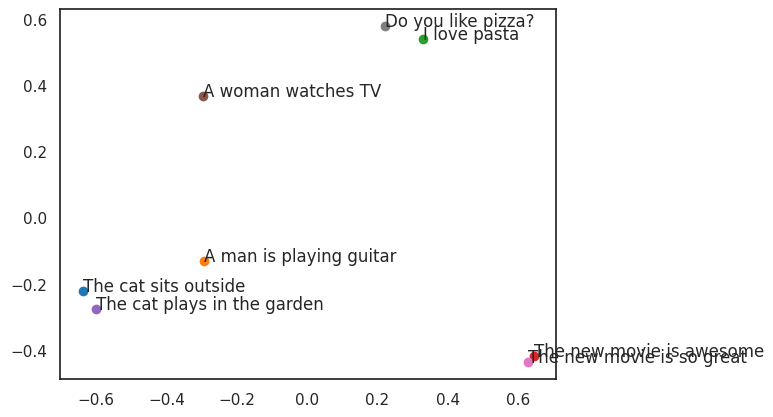

In [13]:
for coord, sentence in zip(embeddings_reduced, sentences):

    plt.scatter(coord[0], coord[1])
    plt.annotate(sentence, (coord[0], coord[1]))

## Using SBERT Embeddings - perfume Recomendation

In [14]:
await skillsnetwork.prepare("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX068IEN/data/perfume_data.tgz", overwrite=True)

  0%|          | 0/2 [00:00<?, ?it/s]

Saved to '.'


In [15]:
df = pd.read_csv("./perfume_data.csv", encoding="unicode_escape")
df.head()

,ï»¿Name,Brand,Description,Notes,Image URL
0,A Blvd. Called Sunset Eau de Parfum,A Lab on Fire,There's no way A Lab On Fire could relocate t...,"Bergamot, almond, violet, jasmine, leather, s...",https://static.luckyscent.com/images/products/...
1,Almost Transparent Blue Eau de Toilette,A Lab on Fire,Almost Transparent Blue takes the classic ele...,"Lime, yuzu, thyme flower, aldehyde, hinoki, c...",https://static.luckyscent.com/images/products/...
2,And The World Is Yours Extrait de Parfum,A Lab on Fire,Few photographs capture the sumptuousness of ...,"Neroli, cumin, orange blossom absolute, rose,...",https://static.luckyscent.com/images/products/...
3,California Snow Eau de Parfum,A Lab on Fire,California Snow crackles with the electricity...,"Sage, tea, chamomile, coumarin, narcissus, ro...",https://static.luckyscent.com/images/products/...
4,Freckled and Beautiful Eau de Parfum,A Lab on Fire,There's no beauty quite like being young in t...,"Orange flower, neroli, honeysuckle, warm milk...",https://static.luckyscent.com/images/products/...


In [16]:
#Let's examine the notes of the perfumes.
list(df.Notes[0:10])

[' Bergamot, almond, violet, jasmine, leather, sandalwood, vanilla, tonka',
 ' Lime, yuzu, thyme flower, aldehyde, hinoki, cedar wood, musk',
 ' Neroli, cumin, orange blossom absolute, rose, heliotrope, sandalwood, vanilla pod CO2,  tonka absolute, tolu balsam',
 ' Sage, tea, chamomile, coumarin, narcissus, rose, hay, cannabis, musk, soil tincture, vetiver, cedar',
 ' Orange flower, neroli, honeysuckle, warm milk, pastry, salicylates, sandalwood, vanilla bean, heliotrope',
 ' Ambrette, bergamot, pink pepper, violet, orris, iriseine, suede, blonde woods, musks',
 ' Juniper, mastic, black pepper, sea salt, clary sage, orris root, olibanum, solar accord, ambergris, vetiver, mineral musks, wet woods, ambrox, sea moss',
 ' Bergamot, lime, saffron, sage, lavender, Hinoki wood, incense, vanilla, musk',
 ' Safran, magnolia petals, Italian mandarin, jasmine sambac, tuberose, orange flower, cereal accord, orris, natural vanilla bean.',
 ' Bergamot, peach blossom, rose, heliotrope, musk, toffee, 

We want the text embeddings to be generated based on the **Notes** column. Thus, we remove redundant columns and organize the data frame.


In [17]:
df.rename(columns={"ï»¿Name": "Name"}, inplace=True)
df['Name'] = df['Brand'] + " - " + df['Name']
df.drop(labels=['Description', 'Image URL', 'Brand'], axis=1, inplace=True)
df.head()

,Name,Notes
0,A Lab on Fire - A Blvd. Called Sunset Eau de P...,"Bergamot, almond, violet, jasmine, leather, s..."
1,A Lab on Fire - Almost Transparent Blue Eau de...,"Lime, yuzu, thyme flower, aldehyde, hinoki, c..."
2,A Lab on Fire - And The World Is Yours Extrait...,"Neroli, cumin, orange blossom absolute, rose,..."
3,A Lab on Fire - California Snow Eau de Parfum,"Sage, tea, chamomile, coumarin, narcissus, ro..."
4,A Lab on Fire - Freckled and Beautiful Eau de ...,"Orange flower, neroli, honeysuckle, warm milk..."


In [18]:
#checking for missing values
df.Notes.isnull().sum()

79

In [19]:
#drop the missing values and reset the indices
df.dropna(inplace = True)
df.reset_index(inplace=True, drop = True)
df.shape

(2097, 2)

We also want to drop other types of fragrances that are <b>not</b> perfumes (e.g. perfume oil, extract, travel spray, hair products, body spray, etc) but might have identical names and similar notes with the perfumes in the dataset.

In [21]:
words = ["Perfume Oil", "Extrait", "Travel", "Hair", "Body", "Hand", "Intense", "Intensivo", "Oil"] # check for these words in perfume names

index_to_drop = []
for index, name in enumerate(df.Name):
    if any(word.lower() in name.lower() for word in words):
        index_to_drop.append(index)

df.drop(index_to_drop, axis=0, inplace=True)
df.reset_index(inplace=True, drop = True)
df.shape

(1604, 2)

## Now lets create Perfume Notes Embeddings

In [22]:
df.Notes = df.Notes.apply(lambda x: str(x))
notes = df.Notes.to_list()
len(notes)

1604

We use the `all-MiniLM-L6-v2` pre-trained SBERT model to generate the sentence embeddings of the perfume notes.


In [23]:
model = SentenceTransformer('all-MiniLM-L6-v2')

note_embeddings = model.encode(notes, show_progress_bar=True, batch_size=64)

Batches:   0%|          | 0/26 [00:00<?, ?it/s]

In [24]:
print(note_embeddings.shape)# check that each generated note embedding has length 384.

print(note_embeddings[0][:50]) # first 50 values in the embedding of "Vanilla bean, musks"

(1604, 384)
[-0.0053617  -0.08962227  0.03425579  0.07611441  0.04399081  0.09172305
  0.03116251 -0.05357345  0.0130553  -0.03158851  0.081012   -0.05667502
 -0.02744403 -0.07322734  0.03848423  0.05993798  0.11013885  0.02569331
 -0.03124174  0.00807239  0.01832666 -0.0001289   0.00550093  0.02377411
  0.01978635  0.02632318  0.02199205 -0.00831314  0.00776821 -0.12470712
  0.0372448  -0.00188032  0.06668037  0.01159846 -0.05619041  0.0182688
 -0.070104   -0.11917054  0.06317987  0.06150826 -0.01092713  0.00840749
 -0.00403327 -0.02480972 -0.0112448  -0.0303256   0.0336121   0.00046362
 -0.00190012  0.0766108 ]


## Recommending Perfums using Cosine Similarity

In [25]:
cosine_scores = util.cos_sim(note_embeddings, note_embeddings)
cosine_scores.shape

torch.Size([1604, 1604])

In [26]:
# Sorting the scores in descending order and appending the (index, score) pair to pairs.
pairs = []

for i in range(len(cosine_scores)-1):
    for j in range(i+1, len(cosine_scores)):
        pairs.append({"index": [i,j], "score": cosine_scores[i][j]})

len(pairs)

1285606

As we have more than 1000 perfumes in the dataset, the number of unique pairs of note embeddings is more than 1M. Next, we sort the pairs based on their corresponding similarity scores, and we print out 10 pairs with the highest scores as the most similar perfumes in the dataset.

In [27]:
sorted_pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)

for pair in sorted_pairs[0:10]:
    i, j = pair['index']
    print(f"{df.iloc[i, 0]} | {df.iloc[j, 0]} \n Score: {pair['score']:.2f} \n")

Comme des Garcons - 2 Eau de Parfum | Comme des Garcons - 2 Candle 
 Score: 1.00 

Roja Parfums - Elysium Parfum Cologne | Roja Parfums - Vetiver Parfum Cologne 
 Score: 1.00 

Ormonde Jayne - Ormonde Elixir Parfum | Ormonde Jayne - Ormonde Woman Eau de Parfum 
 Score: 0.98 

PARFUMS DE NICOLAI - Incense Oud Eau de Parfum | PARFUMS DE NICOLAI - Oud Sublime Elixir de Parfum 
 Score: 0.97 

J-Scent - Hisui (Jade) Eau de Parfum | J-Scent - Shaft of Light Eau de Parfum 
 Score: 0.95 

Roja Parfums - Danger Parfum Cologne | Roja Parfums - Scandal Parfum Cologne 
 Score: 0.94 

Xerjoff - Oud Stars - Alexandria II Eau de Parfum | Xerjoff - Oud Stars - Alexandria III Parfum 
 Score: 0.94 

Charenton Macerations - Asphalt Rainbow Eau de Parfum | Charenton Macerations - Asphalt Rainbow Scratch & Sniff Sticker Set 
 Score: 0.94 

Ormonde Jayne - Ambre Royal Eau de Parfum | Ormonde Jayne - Royal Elixir Parfum 
 Score: 0.94 

Les Bains Guerbois - 2015 Le Phenix Eau de Parfum | Les Bains Guerbois - 

# Testing System

Now let's check how our system works. First, let's write our perfume to the dataset (you can search it up [here](https://www.fragrantica.com/notes/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsIBMGPXX068IEN1371-2022-01-01))

In [32]:
my_perfumes = pd.DataFrame([['Jo Malone - English Pear & Freesia', 'Pear, Melon, Freesia, Rose, Musk, Patchouli, Rhuburb, Amber'],
                      ['Jo Malone - Myrrh & Tonka', 'Lavender, Myrrh, Tonka Bean, Vanilla, Almond'],
                      ['Jo Malone - Oud & Bergamot', 'orange, bergamot, lemon, cedar and oud.'],
                      ['Guerlain - Néroli Outrenoir', 'Petitgrain, Bergamot, Tangerine, Lemon, Grapefruit, Tea, Neroli, Orange Blossom, Smoke, Earthy Notes, Myrrh, Vanilla, Benzoin, Ambrette, Oakmoss.'],
                      ['Guerlain - Épices Volées', 'Coriander, Lemon, Artemisia, Bergamot, Clove, Cardamom, Sage, Bulgarian Rose, Sandalwood, Patchouli, Benzoin, Labdanum.'],
                      ['Guerlain - Aqua Allegoria Nerolia Vetiver Eau de Toilette', 'Basil, Vetiver, Fig Accord, Neroli'],
                      ['Chloe Eau de Parfum', 'Peony, Litchi, Freesia, Rose, Lily-of-the-Valley, Magnolia, Virginia Cedar, Amber.']
                     ],
                   columns=df.columns)

my_perfumes

,Name,Notes
0,Jo Malone - English Pear & Freesia,"Pear, Melon, Freesia, Rose, Musk, Patchouli, R..."
1,Jo Malone - Myrrh & Tonka,"Lavender, Myrrh, Tonka Bean, Vanilla, Almond"
2,Jo Malone - Oud & Bergamot,"orange, bergamot, lemon, cedar and oud."
3,Guerlain - Néroli Outrenoir,"Petitgrain, Bergamot, Tangerine, Lemon, Grapef..."
4,Guerlain - Épices Volées,"Coriander, Lemon, Artemisia, Bergamot, Clove, ..."
5,Guerlain - Aqua Allegoria Nerolia Vetiver Eau ...,"Basil, Vetiver, Fig Accord, Neroli"
6,Chloe Eau de Parfum,"Peony, Litchi, Freesia, Rose, Lily-of-the-Vall..."


In [34]:
def recomend_by(my_perfumes):
    # Create perfume embeddings
    notes = list(my_perfumes.Notes)

    model = SentenceTransformer('all-MiniLM-L6-v2')
    my_embeddings = model.encode(notes, show_progress_bar=True)

    # Produce cosine similarity scores
    cosine_scores = util.cos_sim(my_embeddings, note_embeddings)

    # Sort the perfume similarity scores
    my_pairs = []

    for i in range(cosine_scores.shape[0]):
        for j in range(cosine_scores.shape[1]):
            my_pairs.append({"index": [i,j], "score": cosine_scores[i][j]})

    my_sorted_pairs = sorted(my_pairs, key=lambda x: x['score'], reverse=True)

    # Searching
    for i in range(cosine_scores.shape[0]):
        print(f"Recommended for {my_perfumes.iloc[i, 0]}:")
        my_pairs = []
        for j in range(cosine_scores.shape[1]):
            my_pairs.append({"index": j, "score": cosine_scores[i][j]})
            my_sorted_pairs = sorted(my_pairs, key=lambda x: x['score'], reverse=True)

        for no, pair in enumerate(my_sorted_pairs[:5]):
            print(f" {no+1}. {df.iloc[pair['index'], 0]} (Score: {pair['score']:.2f})")
        print("\n")

In [35]:
recomend_by(my_perfumes)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Recommended for Jo Malone - English Pear & Freesia:
 1. Alexandre. J - Silver Ombre Eau de Parfum (Score: 0.80)
 2. Montale - Starry Nights Eau de Parfum (Score: 0.79)
 3. BDK Parfums - Bouquet de Hongrie Eau de Parfum (Score: 0.79)
 4. Jovoy Paris - Psychedelique Eau de Parfum (Score: 0.79)
 5. L'Artisan Parfumeur - Champ de Fleurs Eau de Cologne (Score: 0.78)


Recommended for Jo Malone - Myrrh & Tonka:
 1. Parfum d'Empire - Fougere Bengale Eau de Parfum (Score: 0.86)
 2. Tauer Perfumes - Une Rose Vermeille Eau de Parfum (Score: 0.84)
 3. Xerjoff - 1861 - Naxos Eau de Parfum (Score: 0.83)
 4. PARFUMS DE NICOLAI - Amber Oud Eau de Parfum (Score: 0.83)
 5. Reims Parfums - L'Eau des Sacres (Score: 0.80)


Recommended for Jo Malone - Oud & Bergamot:
 1. Comme des Garcons: Cologne - Citrico (Score: 0.85)
 2. The House Of Oud - Cypress Shade Eau de Parfum (Score: 0.76)
 3. Xerjoff - Blue Hope Eau de Parfum (Score: 0.76)
 4. L'Artisan Parfumeur - Au Bord De L'Eau Eau de Cologne (Score: 0.76